# Radiomics - 1p/19q Chromosome Status Classification Using Deep Learning

**Special thanks to:**  
- Dr. Bradley J. Erickson M.D., Ph.D. - Department of Radiology - Mayo Clinic
- Panagiotis Korfiatis, Ph.D. - Department of Radiology - Mayo Clinic
- Dr. Daniel LaChance, M.D. - Department of Neurology - Mayo Clinic

## 1, Introduction
Diagnosis of a brain tumor can be devastating to patients. Surgery is an essential step in management, and can be painful and life-threatening. **(a, Old method)** Often the next step is radiation and chemotherapy which also has side effects and is expensive. **(b, New method)** Targeted therapies based on genetic properties of the tumor can improve response and reduce the side effects of treatment.  **(c, Innovation)** Thanks to work being performed at Mayo Clinic, new approaches using deep learning techniques to detect biomarkers can lead to more effective treatments and yield better health outcomes.


## 2, Background

**(a, Definition)**Radiogenomics refers to the correlation between cancer imaging features and gene expression. **(b, Usage)**Radiogenomics can be used to create biomarkers that identify the genomics of a disease without the use of an invasive biopsy. **(c, Definition)**A biomarker is simply an indicator of some biological state or condition. Four biomarkers that appear important for brain tumors include 1p/19q chromosome co-deletion; MGMT-promoter methylation; IDH-1 mutation; and TERT. **(d, Focus of this lab)**The focus of this lab is detection of 1p/19q co-deletion using deep learning, using convolutional neural networks. **(e, Remarkable results)**What is remarkable about this research is the novelty and promising results of combining deep learning with Radiogenomics. **(f, Implication of results)**In addition to avoiding invasive biopsies, the detection or absence of biomarkers is significant because certain treatments of brain tumors are more effective in the presence or absence of a biomarker. Biomarker detection can ensure patients receive the most effective treatment for their particular scenario.

**(Trick#1)**Research performed shows that the detection of 1p/19q co-deletion using deep learning works well with T2 images compared to T1 post contrast images. **(Trick#2)**Additionally, fewer layers and fewer neurons per layer produced better results while limiting overfitting of the training data. The model you will build consists of 14 layers.  **(Trick#3)**Kernels (convolutions) were found to yield positive results when the convolutions were smaller - 3 x 3 - since these smaller convolutions could capture some of the finer details of the edges.  Originally the model was created using Keras and Theano framework, but we have altered the code slightly so that the TensorFlow framework could be used.  Tensorflow has great multi-GPU support - a necessity when working with large training datasets and complex neural networks - hence, the change in framework.

The lab instructions that follow will guide you through one approach to establishing your own convolutional neural network to detect 1p/19q co-deletion biomarker. You will likely experiment with alterations to the network architecture, hyper-parameters and training data. We encourage you to do such experimentation and to utilize deep learning for the detection of other biomarkers


## 3, Getting Started
Before going into details on architecting and training a neural network, there are some housekeeping tasks that need to be executed first.  Examples of such tasks include: 
- Importing libraries
- Locking GPUs to prevent contention issues (if using Theano)
- Changing channel order between frameworks (not shown)

The above list reflects only some of the basic tasks you may need to perform at your site.

Go ahead and place your cursor in each of the three code boxes below and click the "run cell" button.

In [1]:
import os
import sys
import time
import random
import string

import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")  

In [2]:
print ('I am process:')
print (os.getpid())

os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras.layers import Conv2D, MaxPooling2D, Input
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

import numpy as np

from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Activation, Dense, Dropout

I am process:
17


Using TensorFlow backend.


In [3]:
from sklearn.utils import shuffle
from keras.utils import np_utils
from _loadcsvdeep import load_set

import itertools

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn import metrics
from sklearn.cross_validation import train_test_split

import keras
import keras.backend as K

from keras.layers.core import ActivityRegularization
from keras_diagram import ascii
from sklearn.model_selection import StratifiedKFold

import math
seed = 7

from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from sklearn.metrics import confusion_matrix

from collections import Counter

/opt/conda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 4, Network Architecture 
The code block that follows defines our network architecture and provides code that visualizes the model's performance.  Notice how easy it is to define a 14-layer convolution neural network!  Lets take a closer look at some of the layers in the network architecture by exploring the Keras / TensorFlow options used.
<br>
<br>
<br>
**Sequential()**

Immediately after the def cnn_model line below we see the following code: 

*model = Sequential()*

Sequential() is a Keras specification that allows us to create a linear stack of layers in our neural network architecture.
<br>
<br>
<br>
**Conv2D()**

*model.add(Conv2D(16, (3, 3),activation='linear',kernel_initializer='he_uniform'))*

Kernels act like filters.  Each kernel slides over an input image / space to yield a value that projects to a new space (see picture below).  As noted earlier, smaller convolutions offered better results because the smaller convolutions capture some of the finer details of the edges of a tumor.  All convolutional layers in this network use 3 X 3 kernels.  The architecture starts with 16 kernels in a layer, moves to using 32 kernels per layer, then 64 kernels per layer, and reaches a high of 96 kernels per layer.

One of the major advantages of using deep neural networks is that you do not have to define the features yourself.  Convolutions find features in the data for you.  Each kernel needs an initial set of weights. There are numerous approaches to initializing these weights - 'he_uniform' was chosen here.  Feel free to experiment using other weight initilization options.
<br>
<br>
<img src="Convolution.png" width="400" height="300">
<br>
<br>
<br>
**LeakyReLU()**

*model.add(LeakyReLU(alpha=.01))*

LeakyReLU is one of many activation functions (sigmoid, tanh, ReLU, etc.) that can be selected.  Valuable information resides in the negative values when it comes to Radiogenomics.  As such, LeakyReLU was chosen as the activation function since negative values are retained and avoid saturation concerns sometimes experienced when using tanh.
<br>
<br>
<br>
**MaxPooling2D()**

*model.add(MaxPooling2D(pool_size=(2, 2)))*

Pooling is a down-sampling technique that reduces the number of computations that must be performed.  Maxpooling identifies the most important feature in a specified area (2 X 2 given the example above) and projects the maximum value onto a new space.  This model initially uses 2 X 2 maxpooling and then uses 7 X 7 maxpooling.
<br>
<br>
<br>
**Flatten()**

*model.add(Flatten())*

Flattens the input. Does not affect the batch size.
<br>
<br>
<br>
**Dense()**

*model.add(Dense(512))*

Dense reduces the number of neurons in a layer.  Dense is used twice to bring the number of neurons down to two just before the softmax layer to reflect what will be the binary prediction of either 'co-deletion' or 'no co-deletion'.
<br>
<br>
<br>
**GaussianNoise()**

*model.add(keras.layers.noise.GaussianNoise(0.3))*

To prevent overfitting of the training data, noise was intentionally added.
<br>
<br>
<br>
**Dropout()**

*model.add(Dropout(0.5))*

Dropout represents yet another means of preventing or limiting overfitting of your model to the training data.  Dropout randomly avoids neurons during the forward and backward propogation phases.  The number of neurons not updating depends upon the value specified inside Dropout().  In this example, half (0.5) of the neurons are skipped.
<br>
<br>
<br>
**Activation('softmax')**

*model.add(Activation('softmax'))*

The last layer in our network, the output layer, uses a softmax classifier to include the probability of each of the binary outcomes - 'co-deletion' and 'no co-deletion'.

In [4]:
def cnn_model(img_rows, img_cols, img_channels):
    model = Sequential()
    model.add(Conv2D(16, (3, 3),activation='linear',kernel_initializer='he_uniform',
                     input_shape=(img_rows, img_cols, img_channels)))
    model.add(LeakyReLU(alpha=.01))   # add an advanced activation
    model.add(Conv2D(16, (3, 3),activation='linear',kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=.01))   # add an advanced activation
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2)) # Avoid over-fitting 
    model.add(Conv2D(32, (3, 3),activation='linear',kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=.01))   # add an advanced activation
    model.add(Conv2D(32, (3, 3),activation='linear',kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=.01))   # add an advanced activation
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2)) # Avoid over-fitting 
    model.add(Conv2D(64, (3, 3),activation='linear',kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=.01))   # add an advanced activation
    model.add(Conv2D(64, (3, 3),activation='linear',kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=.01))   # add an advanced activation
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3),activation='linear',kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=.01))   # add an advanced activation
    model.add(Conv2D(128, (3, 3),activation='linear',kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=.01))   # add an advanced activation
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(keras.layers.noise.GaussianNoise(0.6))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=.01))   # add an advanced activation
    model.add(Dropout(0.7)) # Avoid over-fitting  
    model.add(Dense(2))
    model.add(Activation('softmax'))

    return model


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.gray,savepdf='output.pdf'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    f=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
#   plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, ('%.2f' %cm[i, j]),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    f.savefig(savepdf)
   
    # This function will set up the weights for problems with unbalanced data. 
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}


## 5, Hyperparameters
Through the course of this research multiple hyperparameter values were tested.  The code below represents the combination of hyperparameters and their corresponding values that provided the best results.  When experimenting with this architecture or adapting it to your own data you may want to alter the values shown here to see if you get better results.  Lets take a closer look at some of the hyperparameters and code shown in the next code block.
<br>
<br>
<br>
**ReduceLROnPlateau()**

*lr_reducer = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=np.sqrt(0.1), cooldown=0, patience=2, min_lr=0.5e-6)*

The learning rate represents how much we move in a certain direction in attempt to find the global minima.  Since initial weight values are somewhat arbitrary, starting with a higher learning rate typically works fine.  As we progress through the training phase, we typically find that we get closer and closer to either the global or local minima.  Since we do not want to overshoot the minima, a common practice is to anneal the learning rate.  In other words, as we progress through the training phase, we start to take smaller and smaller steps in a certain direction.  ReduceLROnPlateau() represents one example of how you can anneal the learning rate.  In the code example above, we will keep reducing the learning rate by the square root of 0.1 when there is no change in the loss value as long as the learning rate has not reached a reduction of 0.5e-6.
<br>
<br>
<br>
**EarlyStopping()**

*early_stopper = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=10)*

Early stopping mechanisms help prevent or limit overfitting models to training data.  Also, early stopping mechanisms prevent unnecessary computations when results remain static.  The model presented here will stop training if for a patience of 10 (epochs) there has not been a change of at least 0.001.
<br>
<br>
<br>
**CSVLogger**

*csv_logger = CSVLogger('qp_logs.csv')*

CSVLogger() allows us to bring in portions of our data into memory instead of having to keep all the data in memory.  Since memory is typically constrained during training, having this option is a necessity in many cases.
<br>
<br>
<br>
**Batch Size**

The batch size indicates the number of images that are processed during forward propagation to yield a loss value that is used in backpropagation.  Typically batch size is set to a power of two and is limited by the amount of memory available.  Also, though larger batch size may allow for faster training, weights update less frequently and may fail to provide the best results.
<br>
<br>
<br>
**Number of Epochs**

The number of epochs represents the number of times the entire training dataset is iterated over when training your model.  Validation, performed at the end of each epoch, identifies how well the model generalizes to new data.

In [5]:
# For network monitoring
# Will reduce the learning rate
lr_reducer = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=np.sqrt(0.1), cooldown=0, patience=10, min_lr=1e-7)

# if used will stop the training when the network stops improving for 10 epochs (patience)
early_stopper = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=10)


# Fit paramters
batch_size = 32

# How many epochs to train
nb_epoch = 10

# Input image dimensions 
scan, img_rows, img_cols = 256, 256, 256
img_channels = 1 # Gray scale images

# Dataset locations 
# TrainingValidation='/home/m112447/Desktop/Python_projects/DEMO_CODE/DATA/1p19q/'+'n43_PQ_Part1'+str(scan)+'.npz'
# Testing='/home/m112447/Desktop/Python_projects/DEMO_CODE/DATA/1p19q/'+'n43_PQ_Part2'+str(scan)+'.npz'
TrainingValidation = os.path.join('/', 'data', 'interTCGA_part1'+str(scan)+'.npz')
Testing = os.path.join('/', 'data', 'interTCGA_part2'+str(scan)+'.npz')

## 6, Data Preparation and Building A Model
The code that follows creates an instance of the previously defined network and will use the previously defined hyperparameters values to build a model.  Code has been injected into various parts of the training phase to provide insight into how the model is progressing.  Also, some data preparation steps are included at the beginning of the following code block - removing a third class, normalizing the data, seting up cross-validation, etc.  Please take a moment to read through the following code before executing as the code reveals several approaches that can be taken in your own research to better understand both the data and the model produced.

Training Validation Size
(1150, 1, 256, 256)
Testing size
(567, 256, 256, 1)
----------------------
A scan which doesn't has a biomarker: 


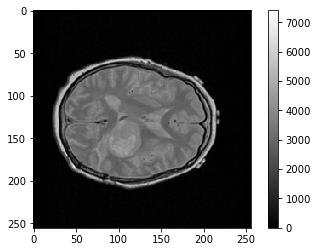



A scan which has a biomarker: 


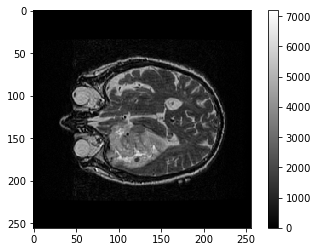

In [43]:
# Load Trainig Validation        
X, y=load_set(path=TrainingValidation,scale=scan)

# Data contain a third class normal --> Remove it for this demo    
IND=np.nonzero(y==2)
y = np.delete(y, IND)
X = np.delete(X, IND,axis=0)
Y_train=y
X_train=X

# Shuffle the training data   
Y_train,X_train = shuffle(Y_train,X_train, random_state=0)
print ('Training Validation Size')
print (np.shape(X_train))
print ('Testing size')
print (np.shape(X_test))
print('----------------------')

# Preview an image
print('''A scan which doesn't has a biomarker: ''')
plt.figure()
plt.imshow(X_train[0,0,:,:], cmap=plt.cm.gray)
plt.colorbar()
plt.show()
print('\n')
print('''A scan which has a biomarker: ''')
plt.figure()
plt.imshow(X_train[1,0,:,:], cmap=plt.cm.gray)
plt.colorbar()
plt.show()

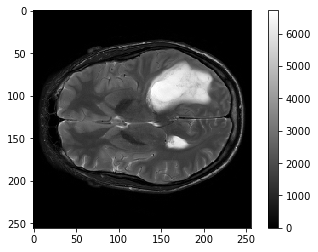

Training Validation Size
(1150, 1, 256, 256)
Testing size
(567, 1, 256, 256)
          InputLayer (None, 256, 256, 1) 
              Conv2D (None, 254, 254, 16)
           LeakyReLU (None, 254, 254, 16)
              Conv2D (None, 252, 252, 16)
           LeakyReLU (None, 252, 252, 16)
        MaxPooling2D (None, 126, 126, 16)
             Dropout (None, 126, 126, 16)
              Conv2D (None, 124, 124, 32)
           LeakyReLU (None, 124, 124, 32)
              Conv2D (None, 122, 122, 32)
           LeakyReLU (None, 122, 122, 32)
        MaxPooling2D (None, 61, 61, 32)  
             Dropout (None, 61, 61, 32)  
              Conv2D (None, 59, 59, 64)  
           LeakyReLU (None, 59, 59, 64)  
              Conv2D (None, 57, 57, 64)  
           LeakyReLU (None, 57, 57, 64)  
        MaxPooling2D (None, 28, 28, 64)  
              Conv2D (None, 26, 26, 128) 
           LeakyReLU (None, 26, 26, 128) 
              Conv2D (None, 24, 24, 128) 
           LeakyReLU (None, 24, 24, 128) 

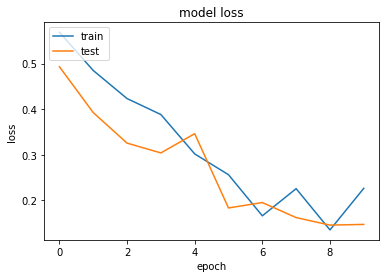

Confusion matrix: Validation
[[261  13]
 [  5 105]]
The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true response that lie in that class.
                   precision    recall  f1-score   support

    1p19q deleted     0.9812    0.9526    0.9667       274
1p19q not deleted     0.8898    0.9545    0.9211       110

      avg / total     0.9550    0.9531    0.9536       384

-------------
-------------
Testing Score
Overall Accuracy: Testing
Categorical Accuracy: 78.13%
The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true respons

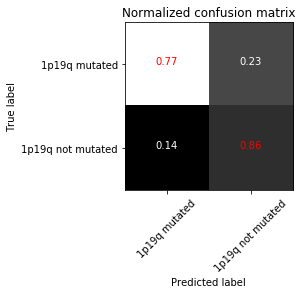

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
('Fold', '2')
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Validation
Overall accuracy: Validation
categorical_accuracy: 95.56%


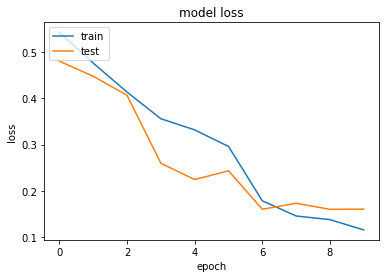

Confusion matrix: Validation
[[265   9]
 [  8 101]]
The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true response that lie in that class.
                   precision    recall  f1-score   support

    1p19q deleted     0.9707    0.9672    0.9689       274
1p19q not deleted     0.9182    0.9266    0.9224       109

      avg / total     0.9558    0.9556    0.9557       383

-------------
-------------
Testing Score
Overall Accuracy: Testing
Categorical Accuracy: 86.07%
The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true respons

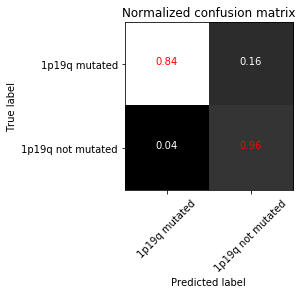

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
('Fold', '3')
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Validation
Overall accuracy: Validation
categorical_accuracy: 97.13%


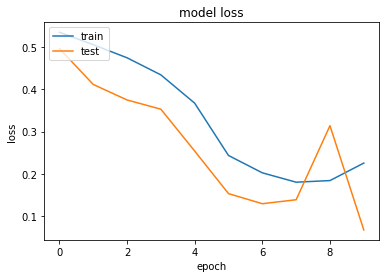

Confusion matrix: Validation
[[265   9]
 [  2 107]]
The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true response that lie in that class.
                   precision    recall  f1-score   support

    1p19q deleted     0.9925    0.9672    0.9797       274
1p19q not deleted     0.9224    0.9817    0.9511       109

      avg / total     0.9726    0.9713    0.9715       383

-------------
-------------
Testing Score
Overall Accuracy: Testing
Categorical Accuracy: 78.66%
The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true respons

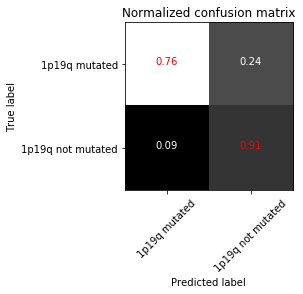

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Summary
96.00% (+/- 0.80%)
0.96% (+/- 0.01%)
0.96% (+/- 0.01%)
0.96% (+/- 0.01%)
80.95% (+/- 3.62%)
0.90% (+/- 0.02%)
0.81% (+/- 0.04%)
0.83% (+/- 0.03%)


In [44]:
if __name__ == "__main__":
    # Location to save the output of these code
    output = os.path.join(os.getcwd(), '1p19qTCGA/')
    if not os.path.exists(output):
        os.makedirs(output)
    csv_logger = CSVLogger(output+'qp_logs.csv')


    # Load Trainig Validation        
    X, y=load_set(path=TrainingValidation,scale=scan)
    
    # Data contain a third class normal --> Remove it for this demo    
    IND=np.nonzero(y==2)
    y = np.delete(y, IND)
    X = np.delete(X, IND,axis=0)
    Y_train=y
    X_train=X
    
    # Delete temporary variables
    del X, y
    
    # Preview an image
    plt.figure()
    plt.imshow(X_train[400,0,:,:], cmap=plt.cm.gray)
    plt.colorbar()
    plt.show()
    
    # Load Testing Validation        
    X, y=load_set(path=Testing,scale=scan)
    
    # Data contain a third class normal --> Remove it for this demo    
    IND=np.nonzero(y==2)
    y = np.delete(y, IND)
    X = np.delete(X, IND,axis=0)
    y_test=y
    X_test=X
    
    # Shuffle the training data   
    Y_train,X_train = shuffle(Y_train,X_train, random_state=0)
    print ('Training Validation Size')
    print (np.shape(X_train))
    print ('Testing size')
    print (np.shape(X_test))
    
    # Normalize the data...the 10000 is set on the dataset creation process  
    # All the data are T2 just used MRIcron to draw a line acrross Z direction of the tumor
    X_train=X_train/10000
    X_test=X_test/10000
    
    X_train=X_train.reshape(-1,img_rows, img_cols, img_channels)
    X_test=X_test.reshape(-1,img_rows, img_cols, img_channels)
    
    model=cnn_model(img_rows, img_cols, img_channels)
    print(ascii(model))
    
    # Save the model in case that needs to be reused
    model_json = model.to_json()
    #with open(output+'/'+"FULL_MODEL.json", "w") as json_file:
    with open(os.path.join(output, 'FULL_MODEL.json'), 'w') as json_file:
        json_file.write(model_json)
    
    # Evaluate the model using three-fold cross validation
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    
    # Keep scores during testing in cross-validation phase
    cvscores = []
    rocval=[]
    prediction=[]
    recall=[]
    f1=[]
    
    i=0
    
    # Keep scores during validation in cross-validation phase
    cvscores_v = []
    rocval_v=[]
    prediction_v=[]
    recall_v=[]
    f1_v=[]
    
    for train, test in kfold.split(X_train, Y_train):
        i+=1
        
        #Will produce a csv file with all the training history
        csv_logger=CSVLogger(output+'/qp_logs'+str(i)+'.csv')
        
        model = cnn_model(img_rows, img_cols, img_channels)
        model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['categorical_accuracy'])
        
        print ('Fold', str(i))
        print (10*'----------')
        print (10*'----------')
        
        # Estimate the weights for this fold
        class_weight = get_class_weights(Y_train[train])
        # Load a pretained model. 
        model.load_weights(os.path.join('/', 'data', 'pretrainedmodel.h5'))       
        # Save the best model
        best_model = ModelCheckpoint(output+'1p19q'+str(i)+'.h5', verbose=0, monitor='val_categorical_accuracy',save_best_only=True)
        
        #Perform the fitting
        history=model.fit(X_train[train], np_utils.to_categorical(Y_train[train],2),
              batch_size=batch_size,
              epochs=nb_epoch,
               validation_data=(X_train[test], np_utils.to_categorical(Y_train[test],2)),
              shuffle=True,
              callbacks=[lr_reducer, csv_logger,early_stopper,best_model],verbose=0)
        
        # Load the weights corresponding to the best model 
        model.load_weights(output+'1p19q'+str(i)+'.h5')
        print ('Validation')
        
        # Estimate accuracy on validation set
        print ('Overall accuracy: Validation')
        scores = model.evaluate(X_train[test],  np_utils.to_categorical(Y_train[test],2), verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores_v.append(scores[1] * 100)
        
        # Plot loss curves
        f = plt.figure()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()      
        f.savefig(output+"1p19q_curves"+str(i)+".pdf")
        
        Y_cv_pred = model.predict(X_train[test], batch_size = 32)
        Y_cv_pred=np.argmax(Y_cv_pred, axis=1)
        Y_cv_pred=np.array(Y_cv_pred)
        Y_cv_pred=Y_cv_pred.astype(int)
        Y_cv_pred = np.squeeze(np.asarray(Y_cv_pred))
        score1 = accuracy_score( Y_train[test], Y_cv_pred)
        
        print('Confusion matrix: Validation')
        print(confusion_matrix( Y_train[test], Y_cv_pred))
        target_names=[]
        
        print ("The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true response that lie in that class.")
        target_names=['1p19q deleted', '1p19q not deleted' ]
        
        print(classification_report( Y_train[test], Y_cv_pred, target_names=target_names,digits=4))
        valid_preds = model.predict(X_train[test], verbose=0)
        prediction_v.append( (metrics.precision_score( Y_train[test], Y_cv_pred,average='weighted')))
        recall_v.append((metrics.recall_score( Y_train[test], Y_cv_pred,average='weighted')))
        f1_v.append(metrics.f1_score( Y_train[test], Y_cv_pred,average='weighted'))
        
        # Accuracy on the Test dataset.  (Not used during the test phase)
        print ('-------------')
        print ('-------------')
        
        print ('Testing Score')
        Y_cv_pred = model.predict(X_test, batch_size = 32)
        Y_cv_pred=np.argmax(Y_cv_pred, axis=1)
        
        print ('Overall Accuracy: Testing')
        score1 = accuracy_score(y_test, Y_cv_pred)
        cvscores.append(score1 * 100)
        print ('Categorical Accuracy: %.2f%%' % (score1 * 100))
        
        print ("The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true response that lie in that class.")
        print(classification_report(y_test, Y_cv_pred, target_names=target_names,digits=4))
        prediction.append( (metrics.precision_score(y_test, Y_cv_pred,average='weighted')))
        recall.append((metrics.recall_score(y_test, Y_cv_pred,average='weighted')))
        f1.append(metrics.f1_score(y_test, Y_cv_pred,average='weighted'))
        
        print('Confustion matrix: Test set')
        print(confusion_matrix( y_test, Y_cv_pred))
        np.set_printoptions(precision=2)
        cmatr=confusion_matrix( y_test, Y_cv_pred)
        np.set_printoptions(precision=2)
        
        # Plot the normalized confusion matrix and save the output
        plot_confusion_matrix(cmatr, classes=['1p19q mutated', '1p19q not mutated' ], normalize=True,
                      title='Normalized confusion matrix',savepdf=output+"1p19qconfusionmatrix"+str(i)+".pdf")
        
        print (10*'----------')
        print (10*'----------')
        
        # Delete the model and history before the next fold
        del model
        del history
    
    print('Summary')
    
    #Validation metrics
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_v), np.std(cvscores_v)))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(prediction_v), np.std(prediction_v)))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(recall_v), np.std(recall_v)))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(f1_v), np.std(f1_v)))
    
    # Test set metrics
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(prediction), np.std(prediction)))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))


## 7, Final Model Build Before Deployment
Once you believe you have captured the best model, then it is time to evaluate a final set of results using all the data to ensure that the model's precision, recall and accuracy are at their optimum.   

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Weights
{0: 1.0, 1: 2.0}


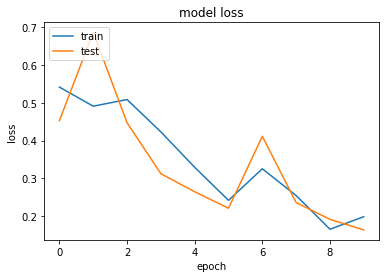

Testing Score
-------------
-------------
Overall Accuracy
Score: 85.71%
The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.  The support is the number of samples of the true response that lie in that class.
                   precision    recall  f1-score   support

    1p19q deleted     0.9541    0.8721    0.9113       477
1p19q not deleted     0.5344    0.7778    0.6335        90

      avg / total     0.8875    0.8571    0.8672       567

Confustion matrix: Test set
[[416  61]
 [ 20  70]]
Normalized confusion matrix
[[ 0.87  0.13]
 [ 0.22  0.78]]


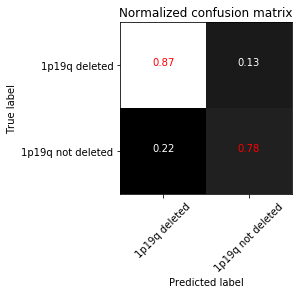

In [45]:
# Create the final data utilizing all the data

model = cnn_model(img_rows, img_cols, img_channels)
model.compile(loss='categorical_crossentropy',
      optimizer='Adam',
      metrics=['categorical_accuracy'])

print (10*'----------')
print (10*'----------')

# Estimate the weights
class_weight = get_class_weights(Y_train)
print('Weights')
print (class_weight)

# Save the best model
best_model = ModelCheckpoint(output+'1p19q_full.h5', verbose=0, monitor='val_categorical_accuracy',save_best_only=True)
model.load_weights(os.path.join('/', 'data', 'pretrainedmodel.h5'))       

# Perform the fitting
history=model.fit(X_train, np_utils.to_categorical(Y_train,2),
      batch_size=batch_size,
      epochs=nb_epoch,
        validation_split=.3,
      shuffle=True,
      callbacks=[lr_reducer, csv_logger,early_stopper,best_model],verbose=0)

# Plot loss curves
f = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()      
f.savefig(output+"1p19q_FULL"+str(i)+".pdf")

# Load best weights 
model.load_weights(output+'1p19q_full.h5')

# Perform analysis on the test set
print ('Testing Score')
print ('-------------')
print ('-------------')
Y_cv_pred = model.predict(X_test, batch_size = 32)
Y_cv_pred=np.argmax(Y_cv_pred, axis=1)

print ('Overall Accuracy')
score1 = accuracy_score(y_test, Y_cv_pred)
print ('Score: %.2f%%' % (score1*100))

print ("The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.  The support is the number of samples of the true response that lie in that class.")
print(classification_report(y_test, Y_cv_pred, target_names=target_names,digits=4))
prediction.append( (metrics.precision_score(y_test, Y_cv_pred,average='weighted')))
recall.append((metrics.recall_score(y_test, Y_cv_pred,average='weighted')))
f1.append(metrics.f1_score(y_test, Y_cv_pred,average='weighted'))

print('Confustion matrix: Test set')
print(confusion_matrix( y_test, Y_cv_pred))
np.set_printoptions(precision=2)
cmatr=confusion_matrix( y_test, Y_cv_pred)
np.set_printoptions(precision=2)

# Plot the normalized confusion matrix and save the output
plot_confusion_matrix(cmatr, classes=target_names, normalize=True,
              title='Normalized confusion matrix',savepdf=output+"1p19qconfusionmatrixfull"+str(i)+".pdf")

## 8, What Next
Many ways to explore and possibly improve model:

- Add additional layers to the network

- Change the number of neurons in those layers

- Change some of the hyperparameters in the network configuration like dropout or learning rate, etc.


Time permitting, go back to the code above and experiment with some of these suggested changes to see if you can achieve better results.